In [ ]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import seaborn as sn
from tqdm import tqdm
from Model_Wrapper import Wrapper
import torch.nn.functional as F
from Datasets import dataset 
from DataLoaders import DataLoader
import helper
import time 

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [86]:
helper.set_random_seed()

Random seed set to: 13


In [87]:
transform_1 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_2 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

color_jitter = transforms.ColorJitter(
    brightness=0.4,  # Adjust brightness by ±40%
    contrast=0.4,    # Adjust contrast by ±40%
    saturation=0.4,  # Adjust saturation by ±40%
    hue=0.1          # Adjust hue by ±10%
)

transform_3 = transforms.Compose([
    transforms.Resize((32, 32)),
    color_jitter,
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define a list of different transforms
transformations = [transform_1, transform_2, transform_3]


In [88]:
# Initialize empty lists to store training and testing datasets
train_datasets = []
test_datasets = []

# Loop through each transformation provided in the 'transformations' list
for transform in transformations:
    # Create a training dataset using the current transformation
    train_ds = dataset(root="images/", transform=transform, split="train")
    train_datasets.append(train_ds)  # Add the training dataset to the list

    # Create a testing dataset using the current transformation
    test_ds = dataset(root="images/", transform=transform, split="test")
    test_datasets.append(test_ds)  # Add the testing dataset to the list

# Define the class labels for the dataset
classes = ("Robots", "Humans")

# Print the size of the last training and testing datasets in the loop
print(f"train size: {train_ds.__len__()} \n test size: {test_ds.__len__()}") 


train size: 339 
 test size: 146


In [89]:
# Initialize lists to store training and testing dataloaders
trainloaders = []
testloaders = []

# Loop through the training and testing datasets in pairs to create diffreent dataloaders 
for train_ds, test_ds in zip(train_datasets, test_datasets):
    trainloader = DataLoader(train_ds, batch_size=32, shuffle=True, num_classes=2)
    trainloaders.append(trainloader)  # Add the training dataloader to the list

    testloader = DataLoader(test_ds, batch_size=32, shuffle=False, num_classes=2)
    testloaders.append(testloader)  # Add the testing dataloader to the list

# Loop through advanced augmentation techniques ("CutMix" and "MixUp") and create their data loaders 
for adv_aug in ["CutMix", "MixUp"]:
    trainloader = DataLoader(
        train_datasets[0], 
        batch_size=32, 
        shuffle=True, 
        num_classes=2, 
        augmentation=adv_aug, 
        alpha=1.5
    )
    trainloaders.append(trainloader)  # Add the augmented training dataloader to the list

    # Create a corresponding test DataLoader for the same dataset without augmentation
    testloader = DataLoader(test_datasets[0], batch_size=32, shuffle=False, num_classes=2)
    testloaders.append(testloader)  # Add the testing dataloader to the list

# Define the class names for better interpretability of results
classes = ["Humans", "Robots"]


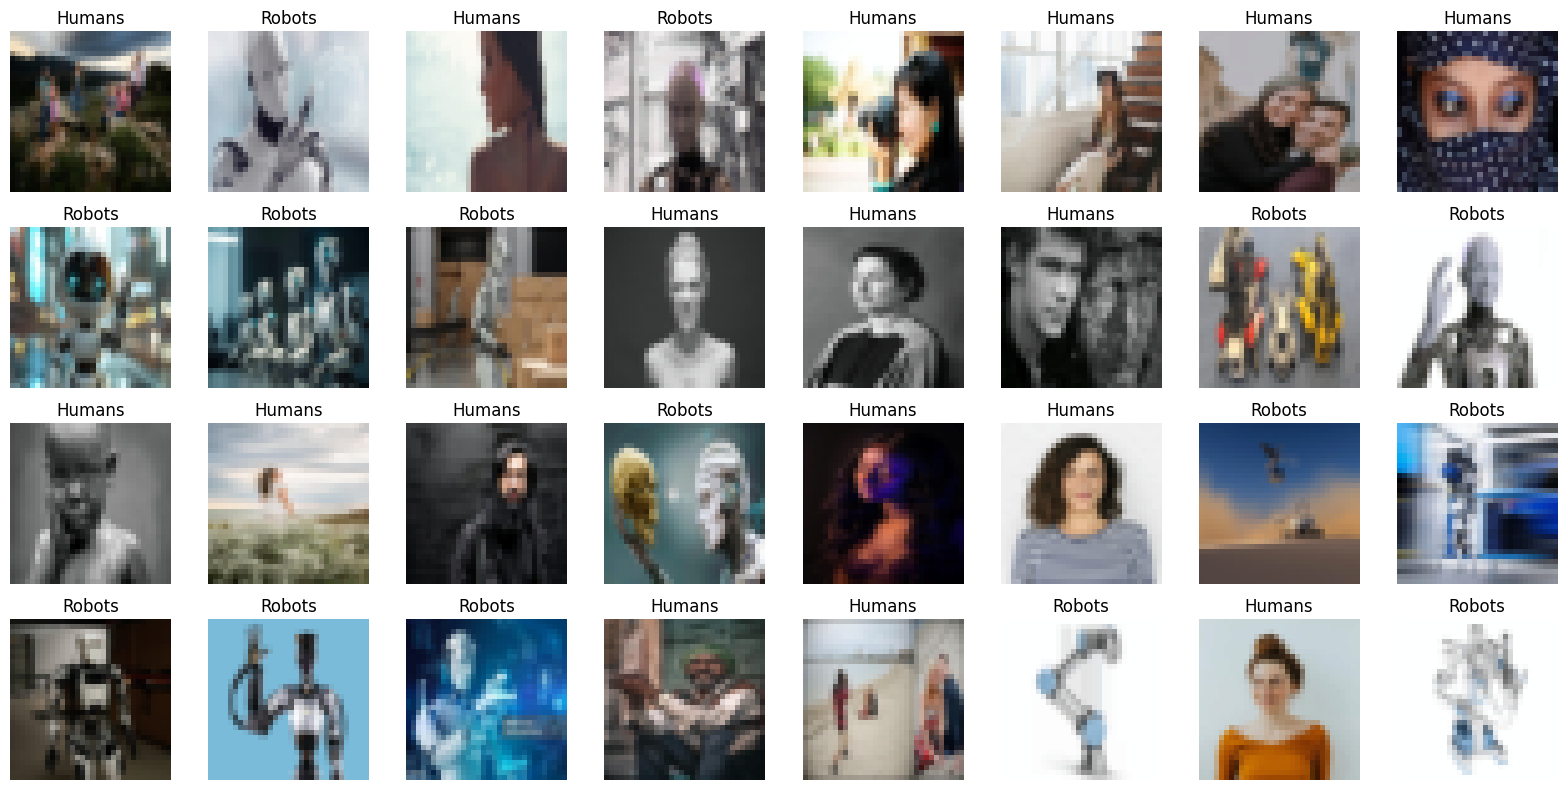

In [90]:
# Simulating a batch from the testloader
inputs, labels = next(iter(testloader)) 

# Map the indices to class names
titles = [classes[label] for label in labels]

# Display the grid
helper.show_grid(inputs, titles)


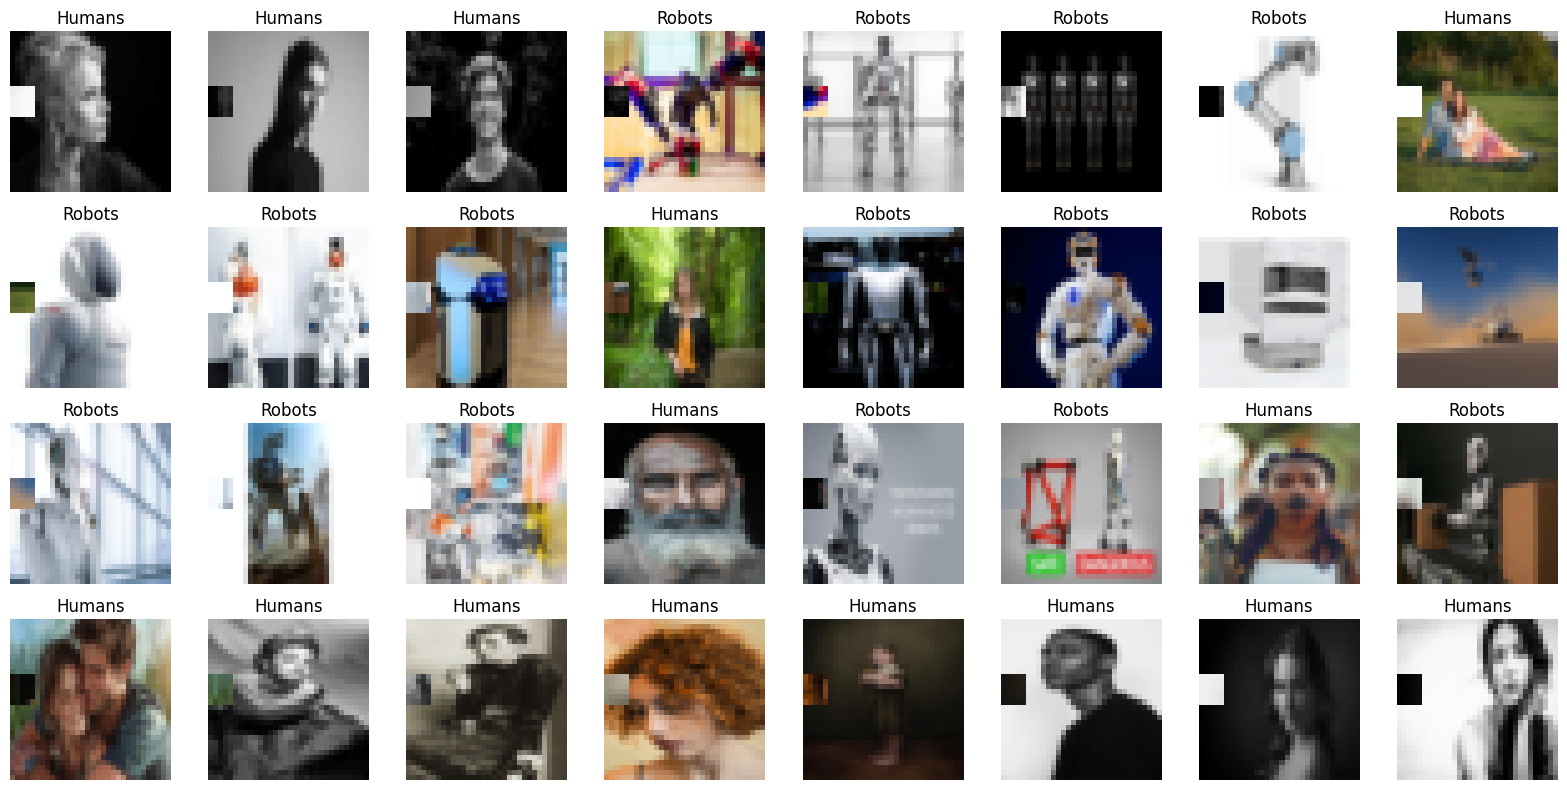

In [91]:
# augmentation for cutmix 
inputs, labels = next(iter(trainloaders[-2]))
titles = [classes[x] for x in labels.argmax(dim=1)]

helper.show_grid(inputs,titles)


# A) fine tune a model with augmented data  

normalization_only test accuracy : 
Validation accuracy: 91.78%


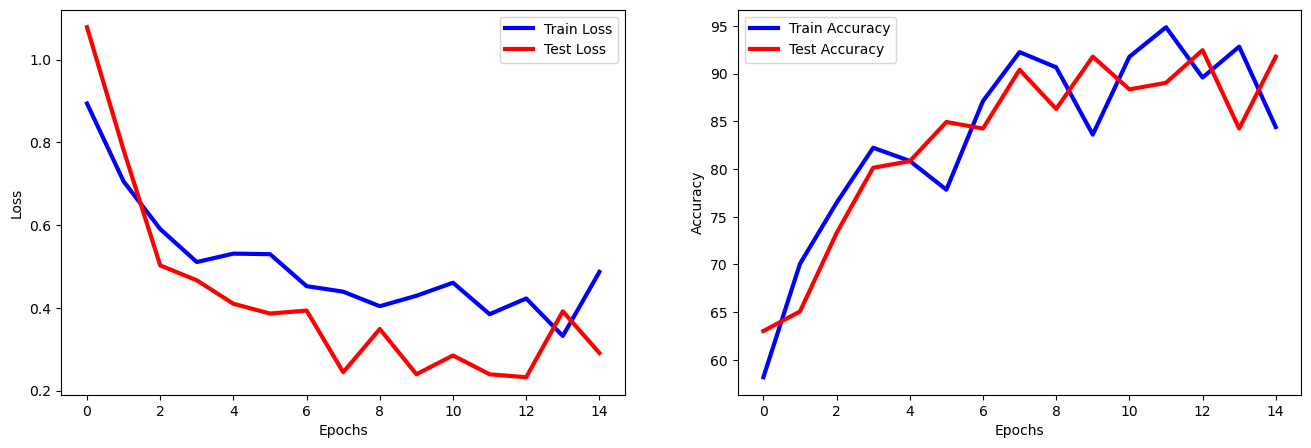

horizontal_flip test accuracy : 
Validation accuracy: 90.41%


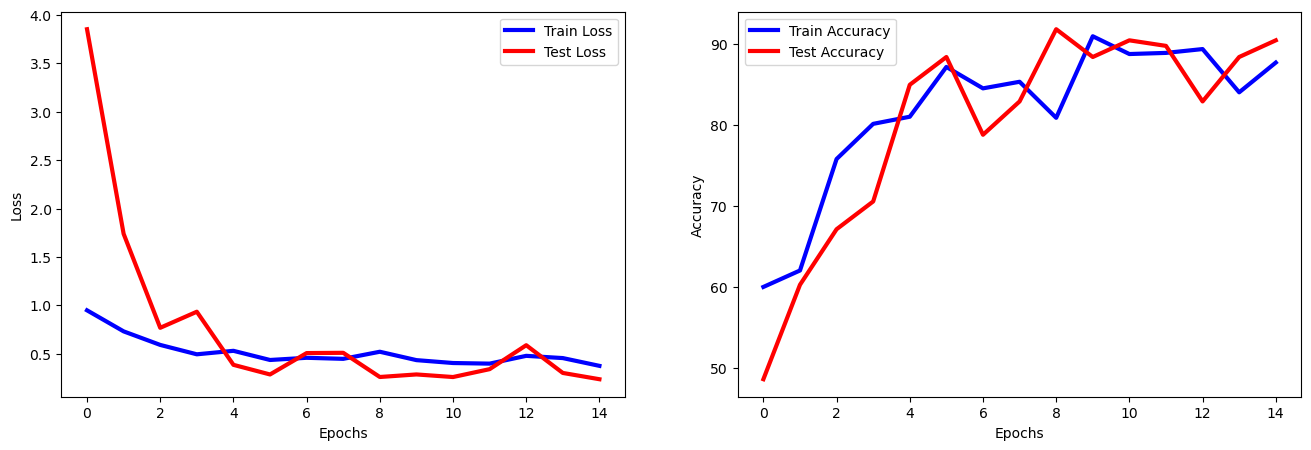

color_jitter test accuracy : 
Validation accuracy: 87.67%


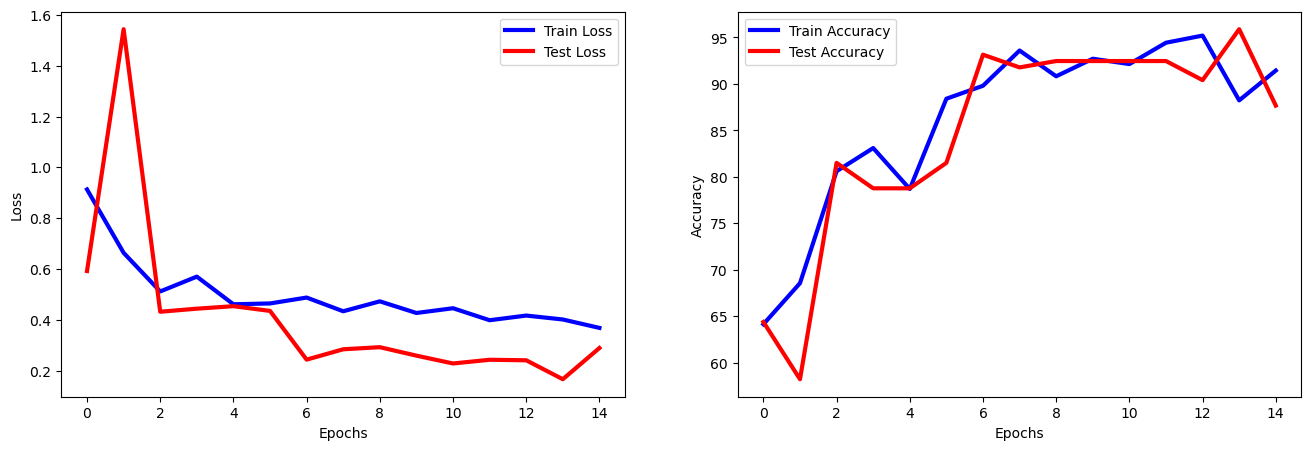

CutMix test accuracy : 
Validation accuracy: 93.84%


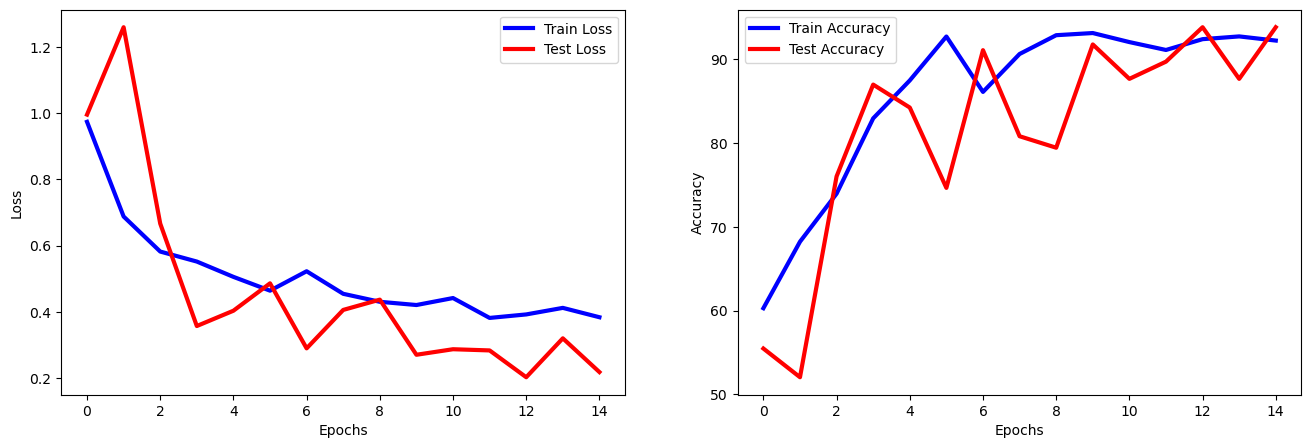

MixUp test accuracy : 
Validation accuracy: 91.1%


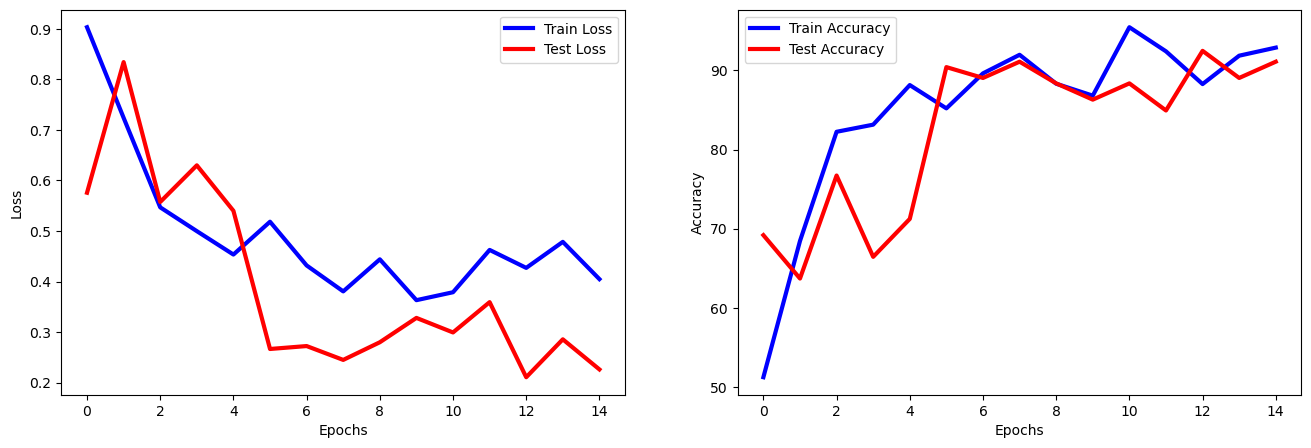

In [11]:
# List of augmentation types
augmentation_type = ["normalization_only", "horizontal_flip", "color_jitter", "CutMix", "MixUp"]

# Loop through augmentations and corresponding data loaders
for i, (train_loader, test_loader) in enumerate(zip(trainloaders, testloaders)):
    
    # Initialize writer
    writer = helper.new_writer("Resnet18+augmentation", augmentation_type[i])
    
    # Initialize model and modify the final layer for binary classification
    model = torchvision.models.resnet18(weights=None)
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, 2) 
    model.to(device)    
    
    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train = Wrapper(model=model, device=device, criterion=criterion, optimizer=optimizer, writer=writer, show_progress_bar=False)
    train.train(15, train_loader, test_loader, classes)
    
    # Print test accuracy and plot metrics
    print(f"{augmentation_type[i]} test accuracy: ")
    train.valid_accuracy()
    train.plot_loss_acc()
    
    # Close writer
    writer.close()

 

The model performs well with different transformations. With the color-jitter the highest change in performance is observed: However, it still manages to achieve an accuracy of 87.67%.

normalization_only test accuracy : 
Validation accuracy: 51.37%


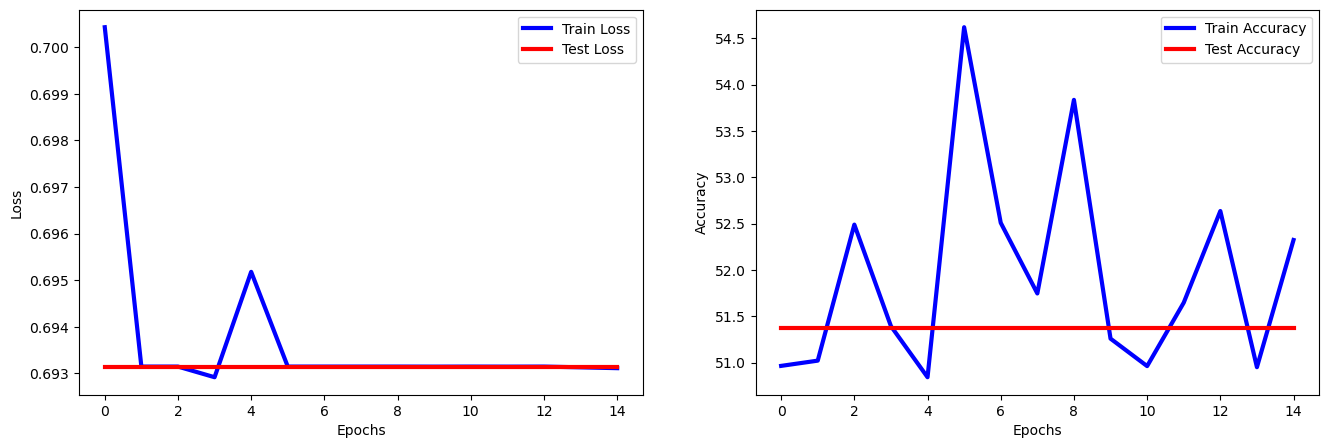

horizontal_flip test accuracy : 
Validation accuracy: 51.37%


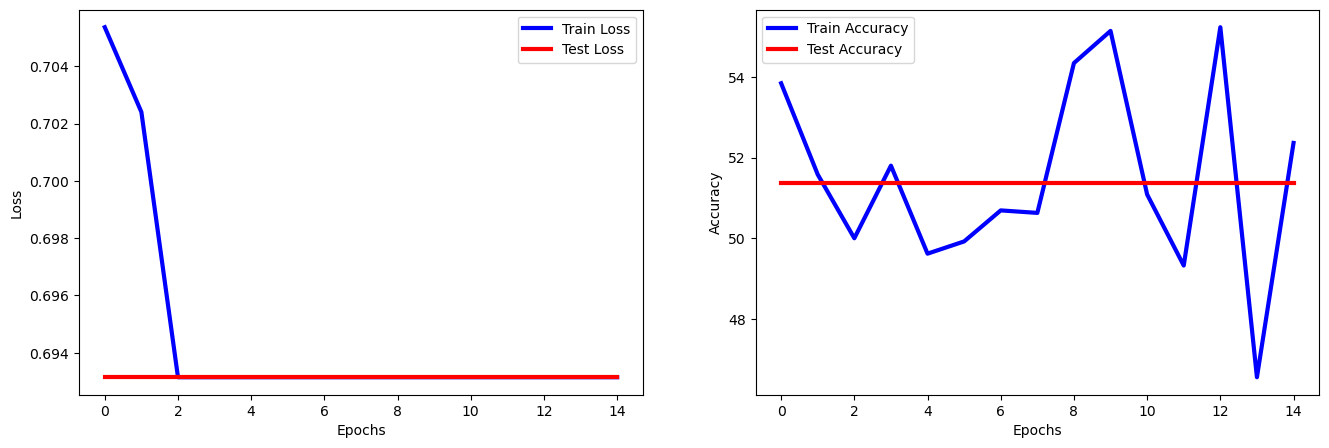

color_jitter test accuracy : 
Validation accuracy: 51.37%


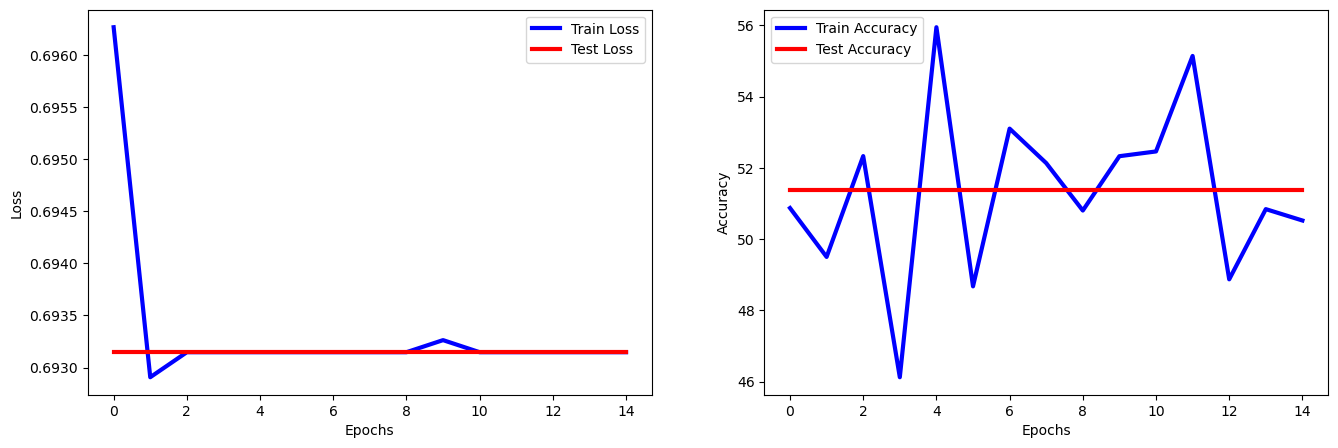

CutMix test accuracy : 
Validation accuracy: 51.37%


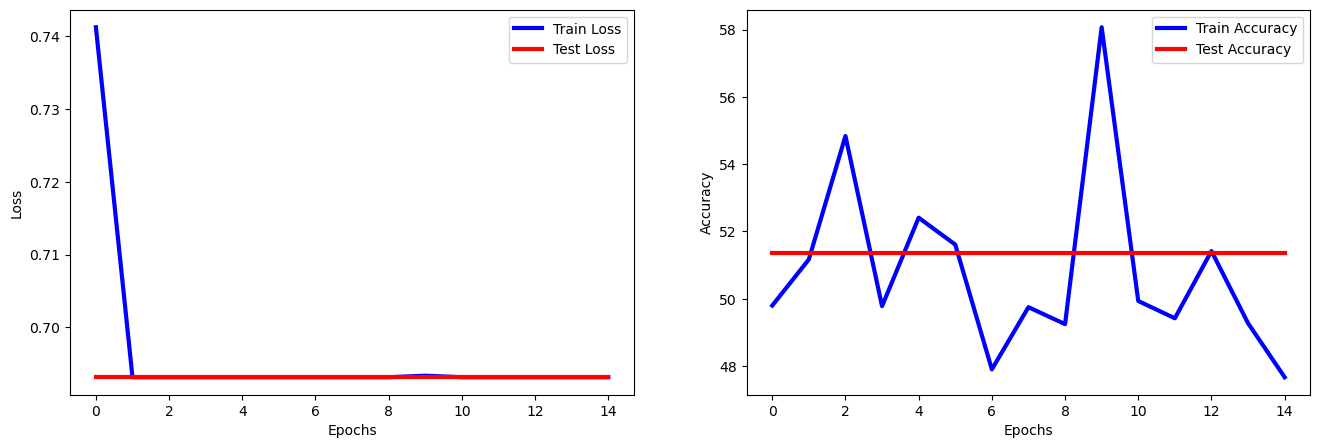

MixUp test accuracy : 
Validation accuracy: 51.37%


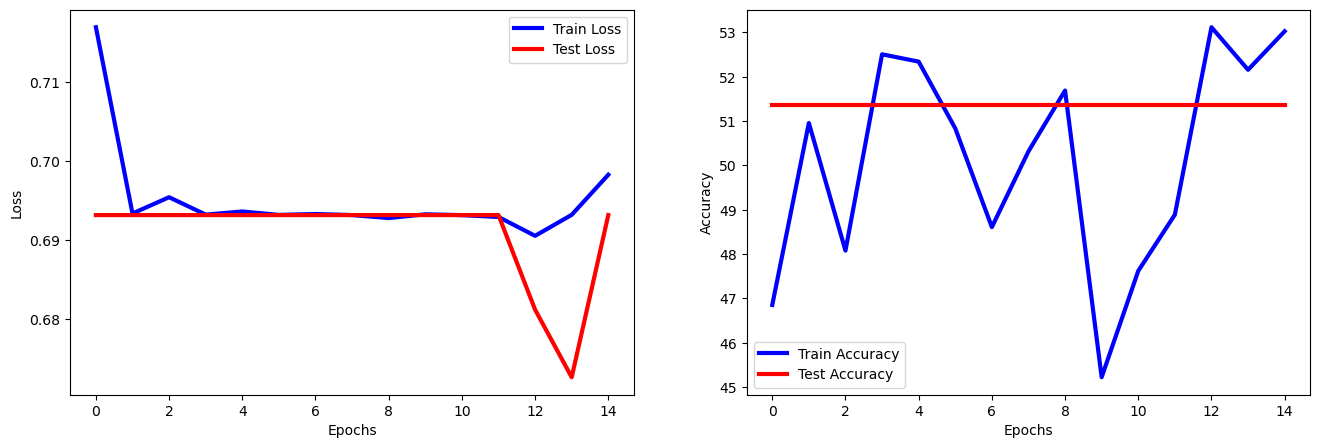

In [12]:
# Loop through augmentations and corresponding data loaders
for i, (train_loader, test_loader) in enumerate(zip(trainloaders, testloaders)):
    
    # Initialize writer
    writer = helper.new_writer("SqueezeNet+augmentation", augmentation_type[i])
    
    # Initialize SqueezeNet model and modify final layer for binary classification
    squeezeNet = torchvision.models.squeezenet1_0(weights=None)
    squeezeNet.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
    squeezeNet.to(device)
    
    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(squeezeNet.parameters(), lr=0.001)
    
    # Train the model
    train = Wrapper(model=squeezeNet, device=device, criterion=criterion, optimizer=optimizer, writer=writer, show_progress_bar=False)
    train.train(15, train_loader, test_loader, classes)
    
    # Print test accuracy and plot metrics
    print(f"{augmentation_type[i]} test accuracy: ")
    train.valid_accuracy()
    train.plot_loss_acc()
    
    # Close writer
    writer.close()

Squeezenet is underfitting overall with no changes in performance with respect to varying transformations

normalization_only test accuracy : 
Validation accuracy: 90.41%


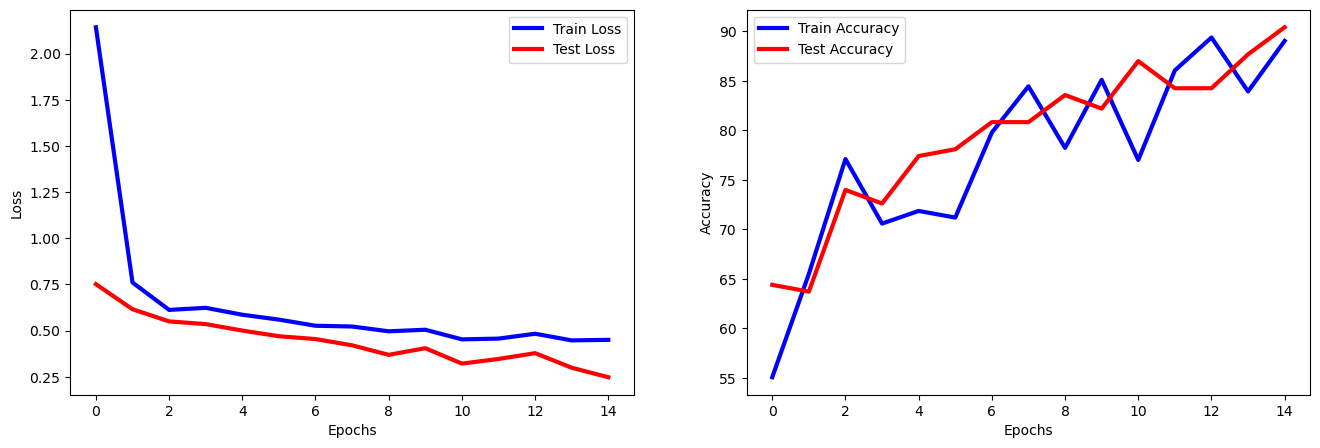

horizontal_flip test accuracy : 
Validation accuracy: 86.3%


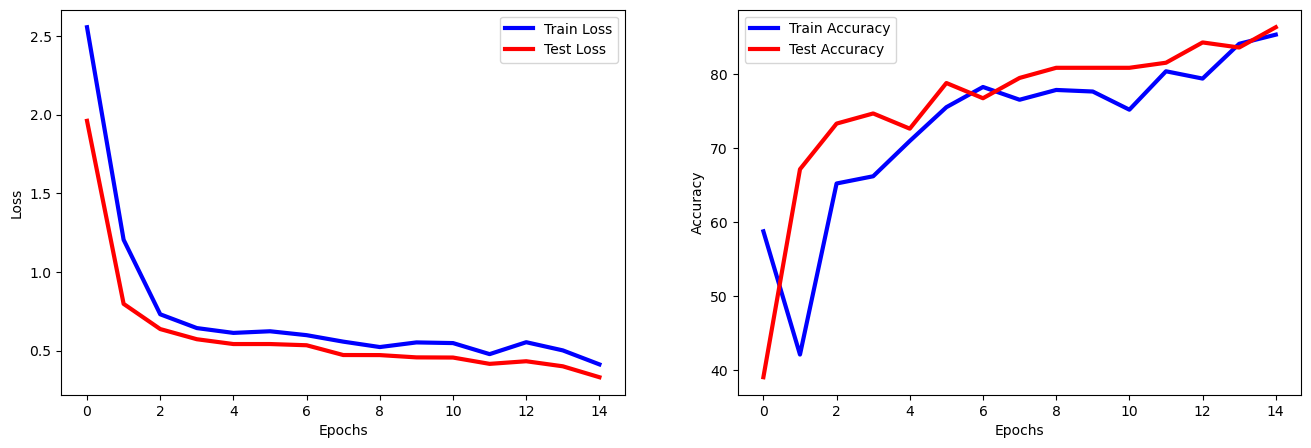

color_jitter test accuracy : 
Validation accuracy: 84.93%


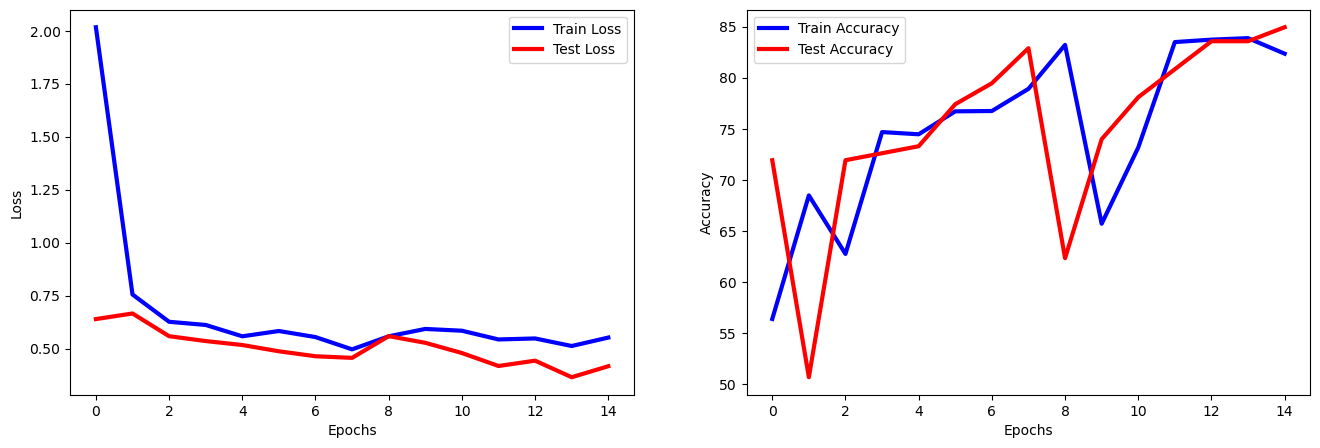

CutMix test accuracy : 
Validation accuracy: 89.04%


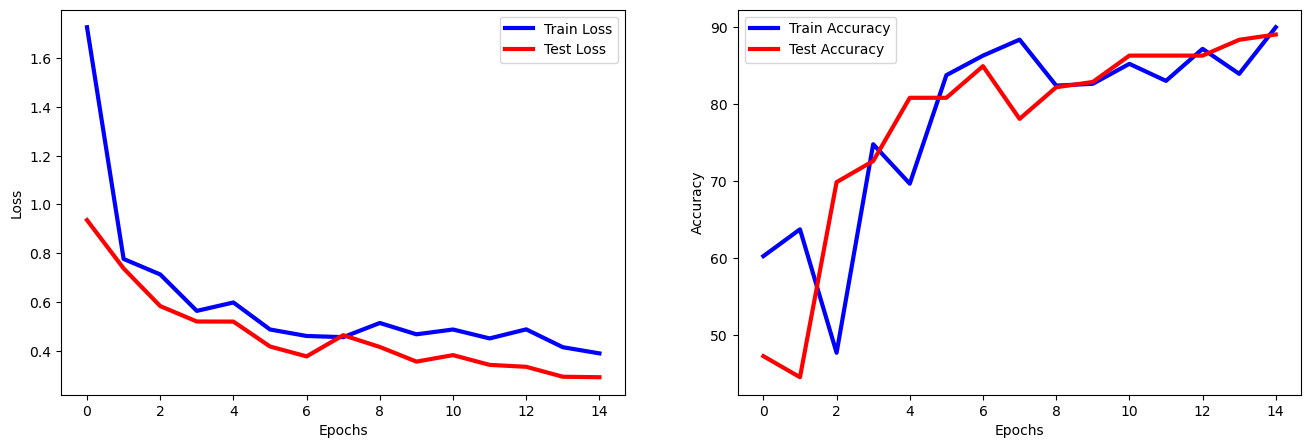

MixUp test accuracy : 
Validation accuracy: 86.99%


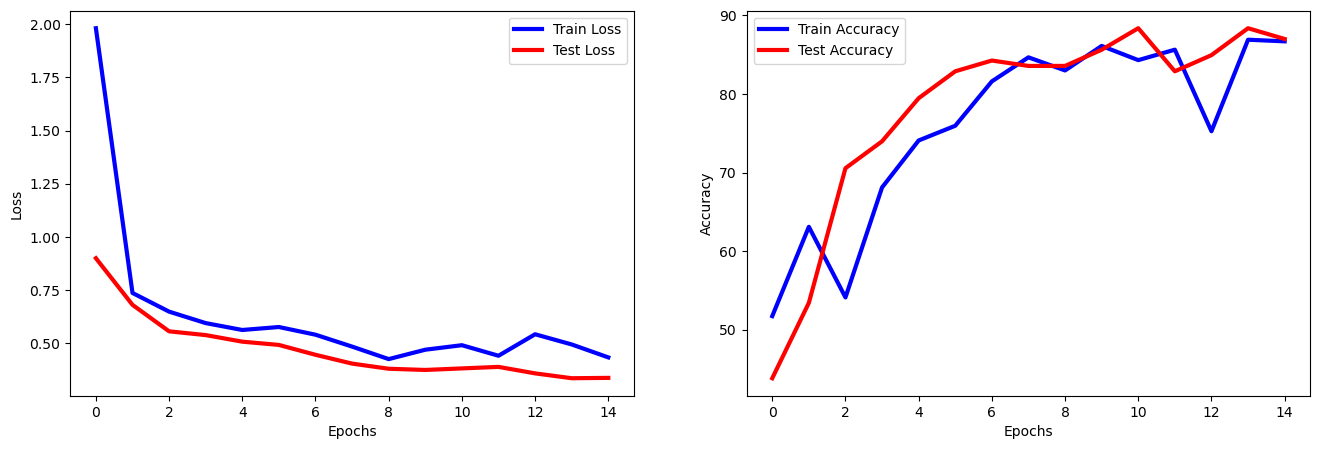

In [13]:
# Loop through augmentations and corresponding data loaders
for i, (train_loader, test_loader) in enumerate(zip(trainloaders, testloaders)):
    
    # Initialize writer
    writer = helper.new_writer("ConvNext+augmentation", augmentation_type[i])
    
    # Initialize ConvNeXt model and modify the final layer for binary classification
    convNext = torchvision.models.convnext_base(weights=None)
    convNext.classifier[2] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)    
    convNext.to(device)
    
    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(convNext.parameters(), lr=0.001)
    
    # Train the model
    train = Wrapper(model=convNext, device=device, criterion=criterion, optimizer=optimizer, writer=writer, show_progress_bar=False)
    train.train(15, train_loader, test_loader, classes)
    
    # Print test accuracy and plot metrics
    print(f"{augmentation_type[i]} test accuracy: ")
    train.valid_accuracy()
    train.plot_loss_acc()
    
    # Close writer
    writer.close()


#### Analysis

ConvNext performs well showing similar results as Resnet with slightly lower performance.

# Fine-tuning

## Resnet18 

Validation accuracy: 91.1%


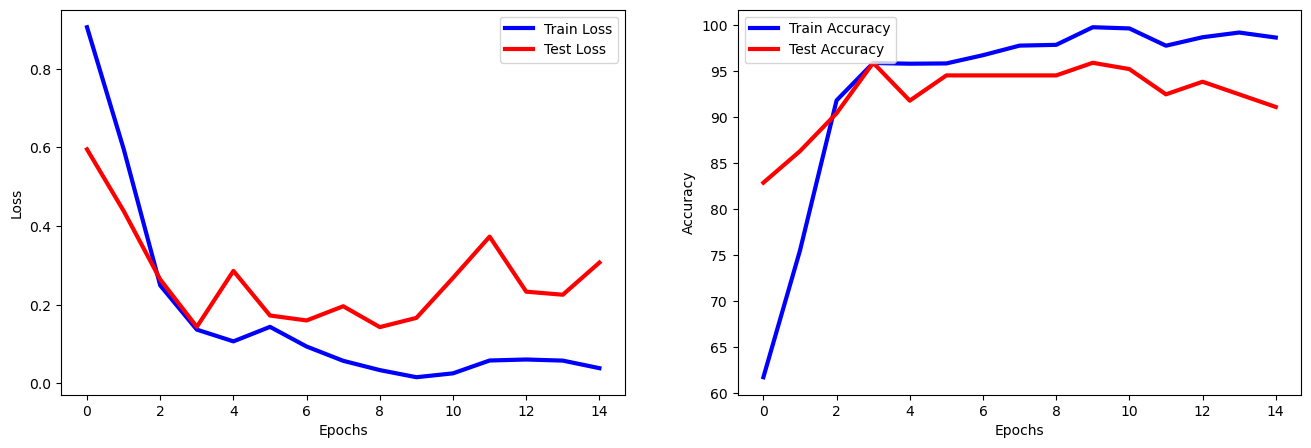

In [14]:
writer = helper.new_writer("fine_tuned","Resnet18")
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
resnet18.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)
train = Wrapper(model = resnet18,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
train.train(15,trainloaders[0],testloaders[0],classes)
train.valid_accuracy()
train.plot_loss_acc()
writer.close()

## SqueezeNet

Validation accuracy: 51.37%


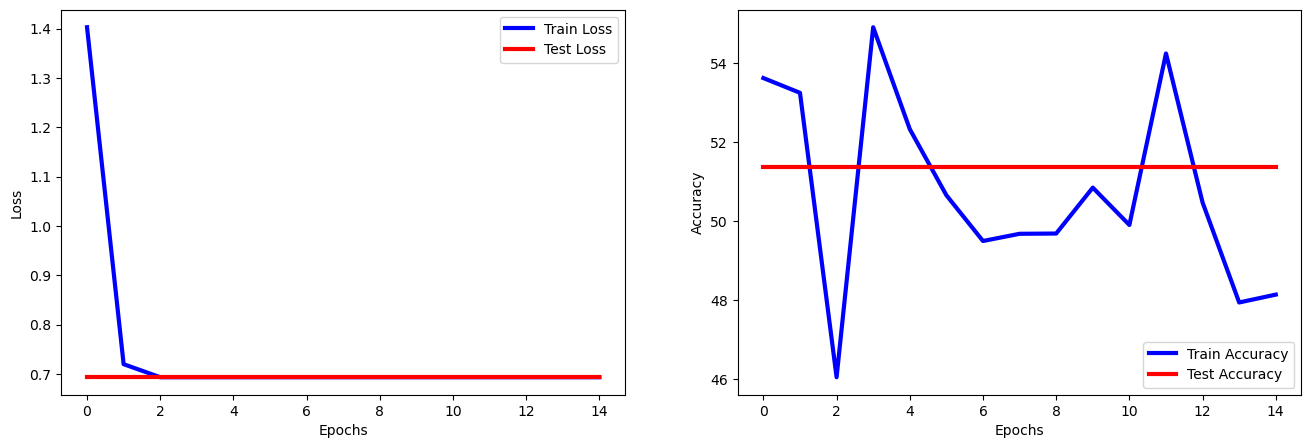

In [15]:
writer = helper.new_writer("fine_tuned","SqueezeNet")
squeezeNet = torchvision.models.squeezenet1_0(weights=torchvision.models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
squeezeNet.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
squeezeNet.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(squeezeNet.parameters(), lr=0.001)
train = Wrapper(model = squeezeNet,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
train.train(15,trainloaders[0],testloaders[0],classes)
train.valid_accuracy()
train.plot_loss_acc()
writer.close()

## ConvNext

Validation accuracy: 93.15%


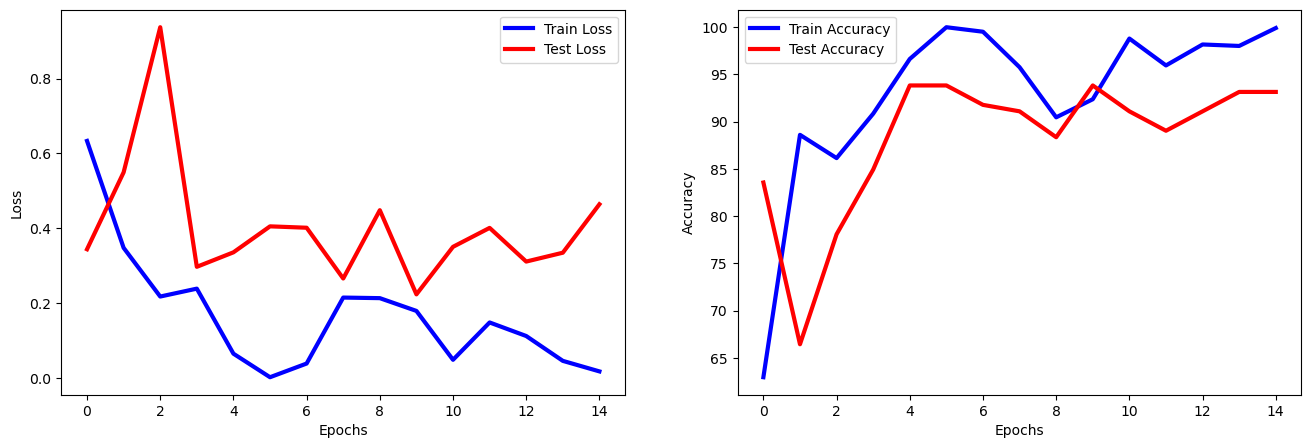

In [16]:
writer = helper.new_writer("fine_tuned","ConvNext")
convNext = torchvision.models.convnext_base(weights=torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
convNext.classifier[2] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
convNext.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convNext.parameters(), lr=0.001)
train = Wrapper(model = convNext,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
train.train(15,trainloaders[0],testloaders[0],classes)
train.valid_accuracy()
train.plot_loss_acc()
writer.close()

#### Analysis

With the first approach of finetuning ConvNext performed the best in overall accuracy, with Resnet in second and SqueezeNet not able to capture the features. Most of the learning happens in the first 6 epochs after that the learning is minimal

# Feature extractor

In [28]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

In [29]:
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [30]:
def train_model(model,writer,epochs=15):
    model.to(device)
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train = Wrapper(model = model,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
    train.train(epochs,trainloaders[0],testloaders[0],classes)
    train.valid_accuracy()
    train.plot_loss_acc()
    return train

## ResNet18

Validation accuracy: 84.25%


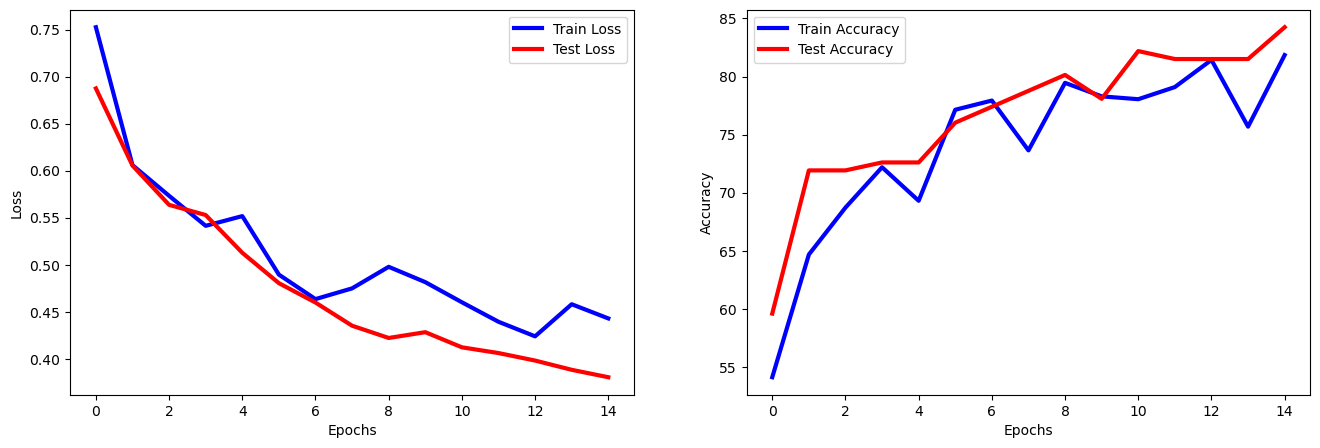

In [31]:
writer = helper.new_writer("feature_extractor","ResNet18")
resnet18_fe = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
# Freezing model parameters
for param in resnet18_fe.parameters():
    param.requires_grad = False
resnet18_fe.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
resnet18_fe.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_fe.parameters(), lr=0.001)
train = Wrapper(model = resnet18_fe,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
train.train(15,trainloaders[0],testloaders[0],classes)
train.valid_accuracy()
train.plot_loss_acc()
writer.close()

## SqueezeNet

Validation accuracy: 51.37%


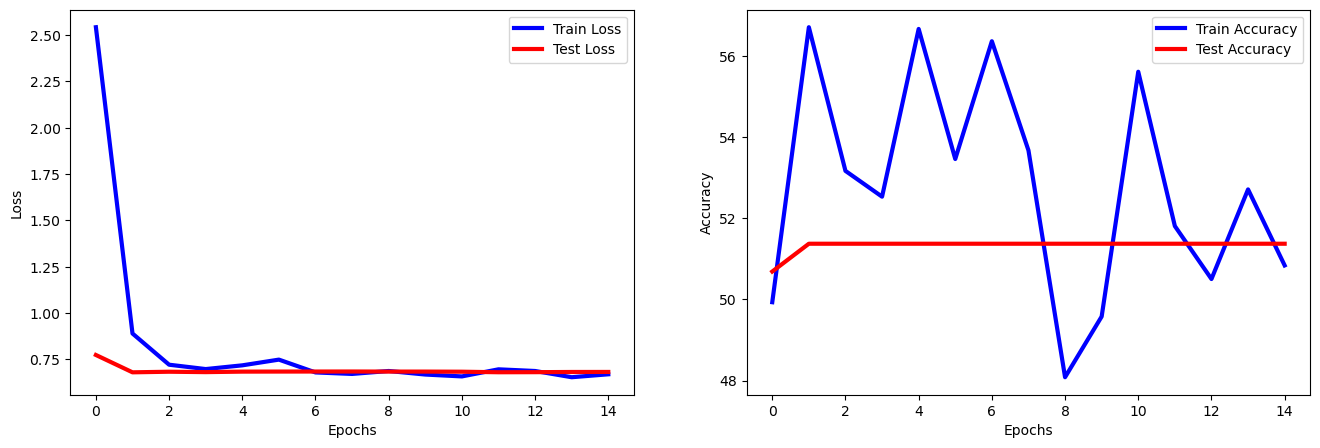

In [32]:
writer = helper.new_writer("feature_extractor","SqueezeNet")
squeezeNet_fe = torchvision.models.squeezenet1_0(weights=torchvision.models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
freeze_model(squeezeNet_fe)
squeezeNet_fe.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
train_squeezeNet = train_model(squeezeNet_fe,writer)
writer.close()

## ConvNext

Validation accuracy: 98.63%


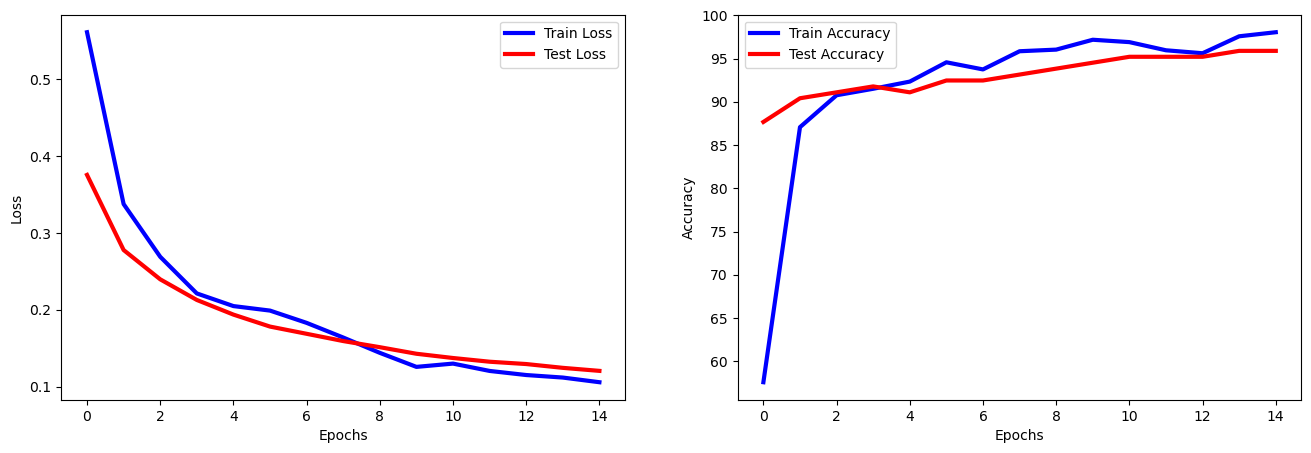

In [23]:
writer = helper.new_writer("feature_extractor","ConvNext")
convNext_fe = torchvision.models.convnext_base(weights=torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
freeze_model(convNext_fe)
convNext_fe.classifier[2] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
train_convNext = train_model(convNext_fe,writer)
writer.close()

#### Analysis
In the feature extractor approach we see ConvNext giving better performance(95.89% as compared to 93.15%) than finetuning which is surprising. With Resnet slightly declining in performance.

# Combined approach

## convNext

In [92]:
def train_model(model,optimizer,writer,scheduler=None,epochs=10):
    model.to(device)
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    train = Wrapper(model = model,device = device, criterion = criterion, optimizer = optimizer,scheduler = scheduler,writer=writer,show_progress_bar= False)
    train.train(epochs,trainloaders[0],testloaders[0],classes)
    return train

In [93]:
writer = helper.new_writer("Combined_approach","ConvNext")
convNext_combined = torchvision.models.convnext_base(weights=torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
freeze_model(convNext_combined)
convNext_combined.classifier[2] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
optimizer = torch.optim.Adam(convNext_combined.parameters(), lr=0.001)
train = train_model(convNext_combined, optimizer, writer, epochs=5)
unfreeze_model(convNext_combined)
# Halve the learning rate for fine-tuning phase 
for g in optimizer.param_groups:
    g["lr"] *= 0.5
train_convNext_combined = train_model(convNext_combined,optimizer,writer, epochs=5)
train_convNext_combined.valid_accuracy()
writer.close()

Validation accuracy: 95.21%


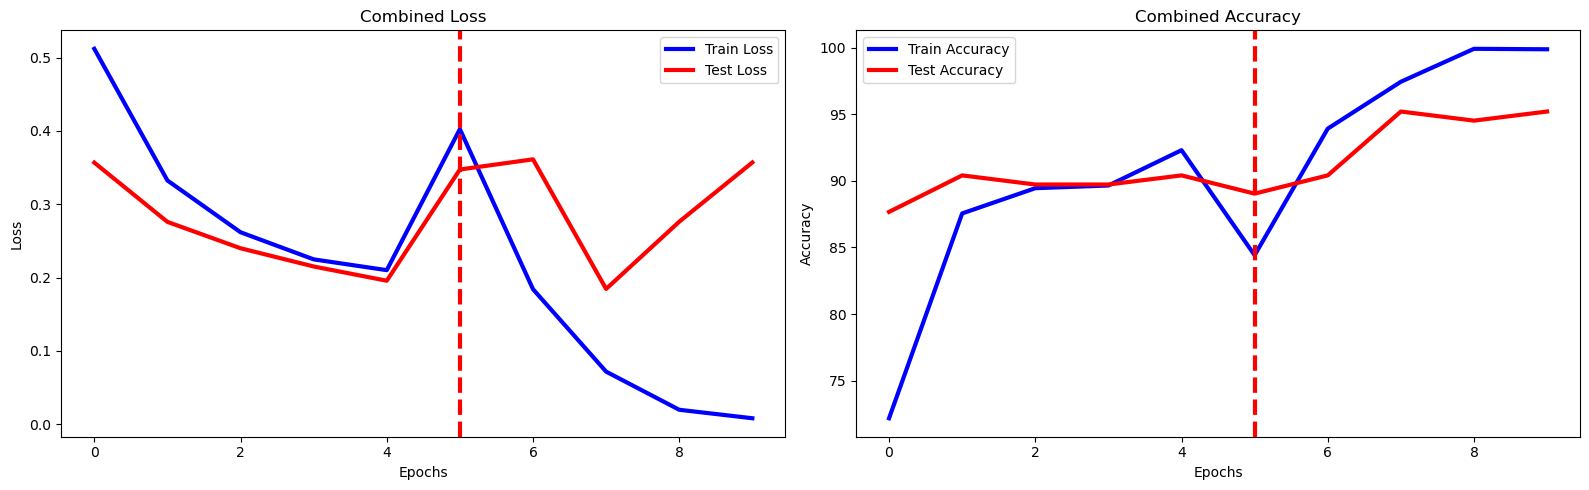

In [43]:
helper.plot_combined_loss_acc(train,train_convNext_combined,line = 5)


## Resnet18

In [44]:
# Initialize the writer for ResNet18
writer_resnet = helper.new_writer("Combined_approach", "ResNet18")
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze the ResNet18 model
freeze_model(resnet18)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)  

# Define optimizer 
optimizer_resnet = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Train ResNet18 - Phase 1
train_resnet = train_model(resnet18, optimizer_resnet, writer_resnet, epochs=5)

# Unfreeze for fine-tuning
unfreeze_model(resnet18)
for g in optimizer_resnet.param_groups:
    g["lr"] *= 0.5

# Train ResNet18 - Phase 2
train_resnet_b = train_model(resnet18, optimizer_resnet, writer_resnet, epochs=5)
train_resnet_b.valid_accuracy()

# Close writer for ResNet18
writer_resnet.close()


Validation accuracy: 91.78%


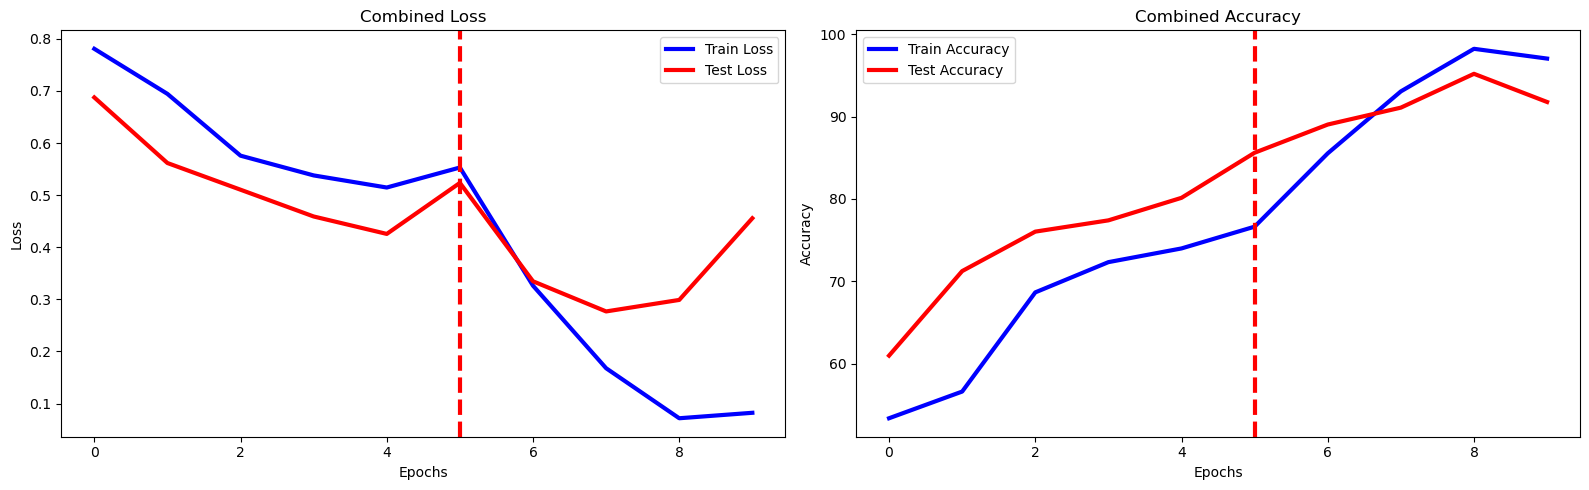

In [45]:
helper.plot_combined_loss_acc(train_resnet,train_resnet_b,line = 5)


## SqueezNet

In [46]:
# Initialize the writer for SqueezeNet
writer_squeezenet = helper.new_writer("Combined_approach", "SqueezeNet")
squeezenet = torchvision.models.squeezenet1_1(weights=torchvision.models.SqueezeNet1_1_Weights.IMAGENET1K_V1)

# Freeze the SqueezeNet model
freeze_model(squeezenet)
squeezenet.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
torch.nn.init.xavier_uniform_(squeezenet.classifier[1].weight)  

# Define optimizer 
optimizer_squeezenet = torch.optim.Adam(squeezenet.parameters(), lr=0.001)

# Train SqueezeNet - Phase 1
train_squeezenet = train_model(squeezenet, optimizer_squeezenet, writer_squeezenet, epochs=5)

# Unfreeze for fine-tuning
unfreeze_model(squeezenet)
for g in optimizer_squeezenet.param_groups:
    g["lr"] *= 0.5

# Train SqueezeNet - Phase 2
train_squeezenet_b = train_model(squeezenet, optimizer_squeezenet, writer_squeezenet, epochs=5)
train_squeezenet_b.valid_accuracy()

# Close writer for SqueezeNet
writer_squeezenet.close()


Validation accuracy: 51.37%


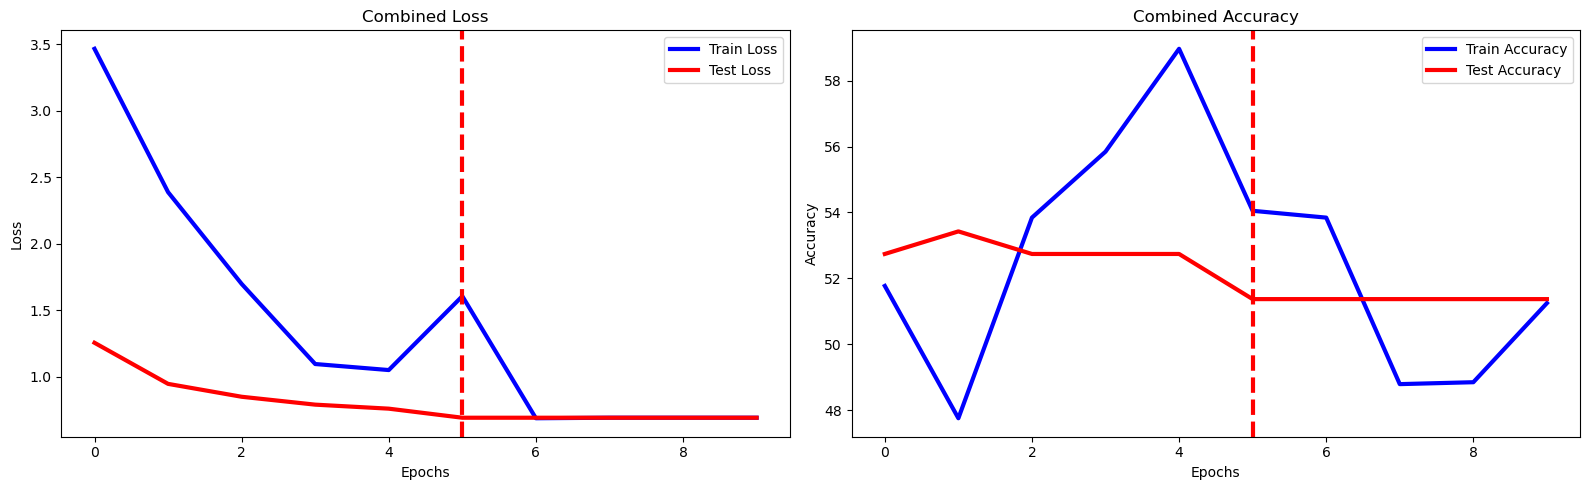

In [47]:
helper.plot_combined_loss_acc(train_squeezenet,train_squeezenet_b,line = 5)

#### Analysis

In the combined approach we can see that ConvNext works really well even just as a feature extractor because before finetuning starts, it is still showing good results. However, performance increases after finetuning.
In ResNet there is comparative much more improvement with finetuning. The graph shows an steady increase in performance.
SqueezeNet was not able to show good results on our datasets for each of the approach showing that it was not able to learn the features.


# our best performed model vs swim transformer

Validation accuracy: 91.1%


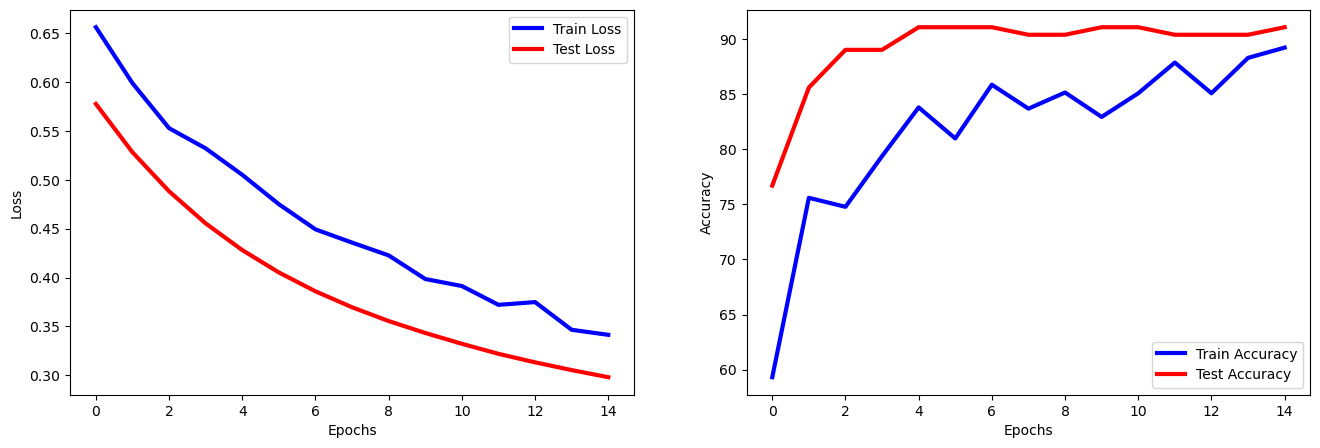

Training Time 1: 157.05 seconds


In [37]:
# best transformation  
writer = helper.new_writer("best_performed","ConvNext")
convNext_fe = torchvision.models.convnext_base(weights=torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
freeze_model(convNext_fe)
convNext_fe.classifier[2] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
convNext_fe.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convNext_fe.parameters(), lr=0.001)
train = Wrapper(model = convNext_fe,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
start_time = time.time()
train.train(15,trainloaders[0],testloaders[0],classes)
end_time = time.time()
train.valid_accuracy()
train.plot_loss_acc()
writer.close()
# Calculate the elapsed time
training_time = end_time - start_time
print(f"Training Time : {training_time:.2f} seconds")


[[66  9]
 [ 4 67]]


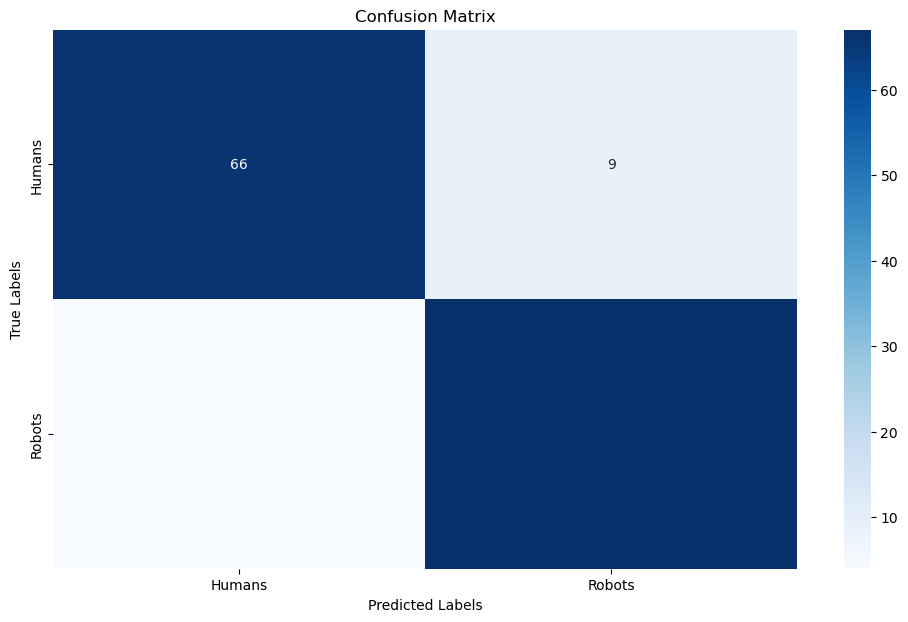

In [38]:
train.confusion_matrix()

Validation accuracy: 95.89%


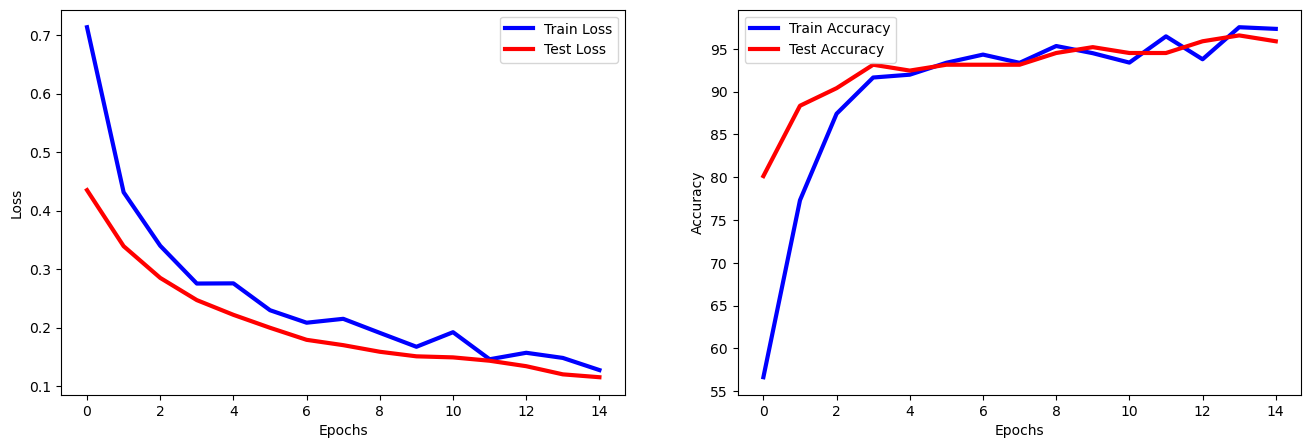

Training Time : 155.11 seconds


In [39]:
# best transformation  
writer = helper.new_writer("bonus","swim_transformer")
swim_model = torchvision.models.swin_t(weights='IMAGENET1K_V1')
freeze_model(swim_model)


num_features = swim_model.head.in_features
swim_model.head = torch.nn.Linear(num_features, 2)
swim_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(swim_model.parameters(), lr=0.001)
train = Wrapper(model = swim_model,device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= False)
start_time = time.time()
train.train(15,trainloaders[0],testloaders[0],classes)
end_time = time.time()
train.valid_accuracy()
train.plot_loss_acc()
writer.close()
# Calculate the elapsed time
training_time = end_time - start_time
print(f"Training Time : {training_time:.2f} seconds")

[[71  4]
 [ 2 69]]


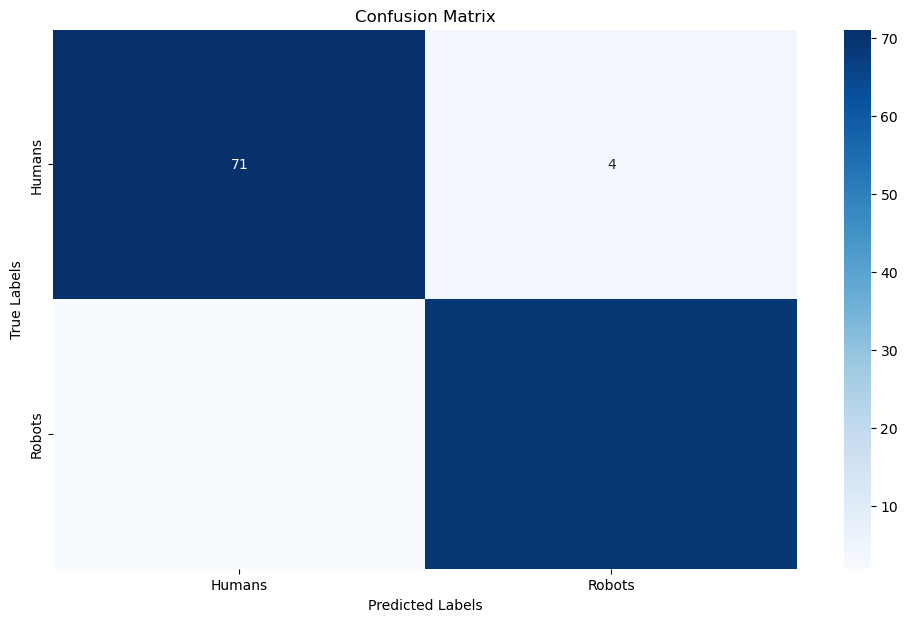

In [40]:
train.confusion_matrix()

In [105]:
image_paths = ["test_images/Robots/"+image_path for image_path in os.listdir("test_images/Robots")]

In [100]:
from PIL import Image

In [131]:
images = []
input_tensors = []
for path in image_paths:
    image = Image.open(path).convert("RGB")
    images.append(image)
    input_tensors.append((transformations[0](image)).to(device))

In [121]:
input_batch = torch.stack(input_tensors)

In [122]:
with torch.no_grad():
    outputs = convNext_combined(input_batch)

In [124]:
predictions = (torch.sigmoid(outputs) > 0.5).squeeze().cpu().numpy()

In [125]:
predictions

array([[False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False]])

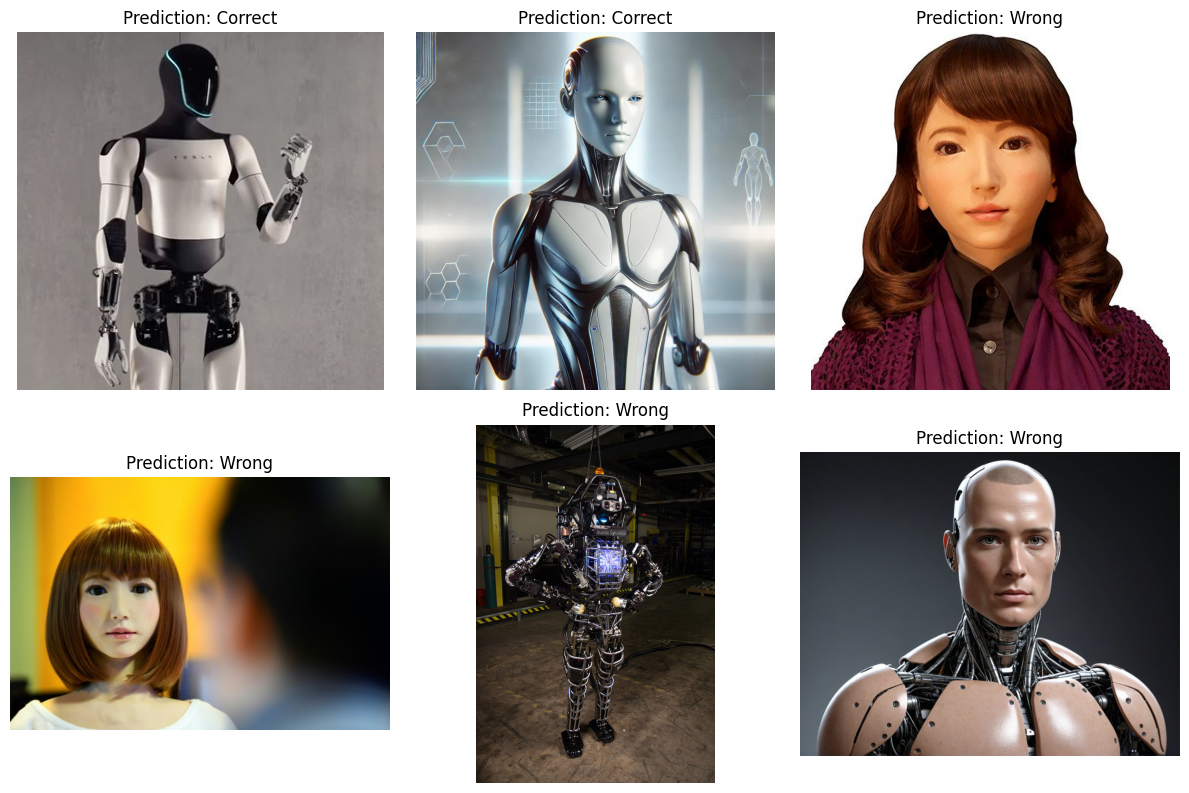

In [132]:
plt.figure(figsize=(12, 8))
for i, image in enumerate(images):
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Prediction: {'Correct' if predictions[i][1] else 'Wrong'}")
plt.tight_layout()
plt.show()

We can see that our model performs better on images of generic robots. However, when robots are specifically designed with making their appearance realistic like humans then the model gets the classfication wrong.